In [608]:
import pandas as pd
import numpy as np
import os
import re
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)
MA_WINDOW = 5*24

In [609]:
path = f'../../data/TUMTUMTUM/DF_Combined_2025_1h.csv'
df = pd.read_csv(path)
df = df[[col for col in df.columns if not col.startswith('RAYUSDT')]]
df['open_time'] = pd.to_datetime(df['open_time'])
df['open_time'] = pd.to_datetime(df['open_time']).dt.tz_localize(None)
print(f'DF shape - {df.shape}')


def get_coins(df: pd.DataFrame) -> list:
    cols = df.columns.tolist()
    coins = []
    for col in cols:
        if col.endswith('_open'):
            coin = col[:-5]
            coins.append(coin)
    return coins

df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

DF shape - (6785, 247)


,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET
0,0.82160,0.82180,0.81620,0.81670,1413940,-0.00596
1,0.81650,0.83950,0.81310,0.83920,2434099,0.02755
2,0.83930,0.83980,0.82920,0.83050,1066893,-0.01037
3,0.83050,0.83520,0.82730,0.83320,1109688,0.00325
4,0.83310,0.83350,0.82540,0.82610,714500,-0.00852


In [610]:
def add_coin_moving_average(df: pd.DataFrame, field: str = "close", window: int = MA_WINDOW, center: bool = True) -> pd.DataFrame:
    """
    Add moving average columns for each coin's <field> column (e.g., 'JUPUSDT_close').
    Creates columns like '<coin>_<field>_MA{window}'.
    """
    out = df.copy()
    pat = re.compile(fr"^(?P<coin>.+?)_{re.escape(field)}$")
    target_cols = [c for c in df.columns if pat.match(c)]

    for col in target_cols:
        ma_col = f"{col}_MA{window}{'_centered' if center else ''}"
        out[ma_col] = out[col].rolling(window=window, min_periods=10, center=center).mean()

    out = out.dropna()

    return out

df = add_coin_moving_average(df, field="close")

df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()


,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_close_MA120_centered
0,0.82160,0.82180,0.81620,0.81670,1413940,-0.00596,0.87570
1,0.81650,0.83950,0.81310,0.83920,2434099,0.02755,0.87695
2,0.83930,0.83980,0.82920,0.83050,1066893,-0.01037,0.87801
3,0.83050,0.83520,0.82730,0.83320,1109688,0.00325,0.87900
4,0.83310,0.83350,0.82540,0.82610,714500,-0.00852,0.88034


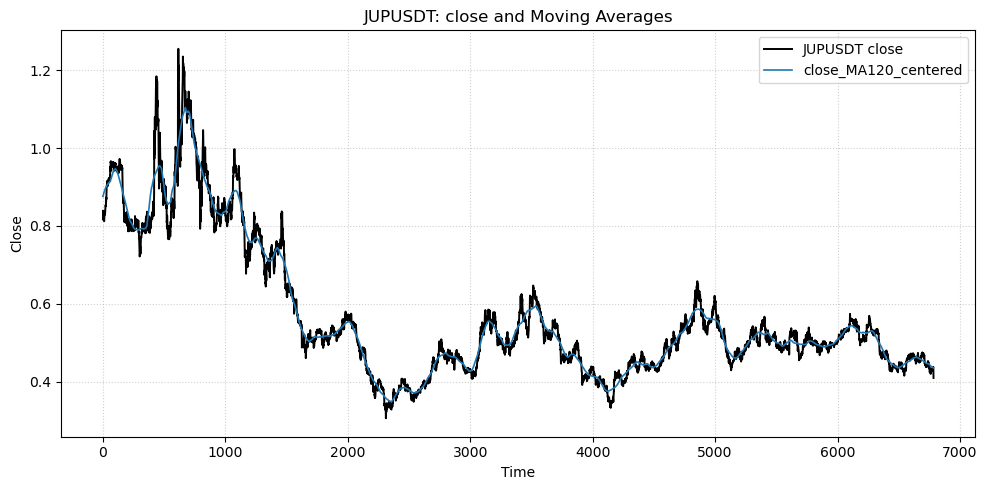

In [611]:
def plot_coin_with_existing_mas(
    df: pd.DataFrame,
    coin: str,
    field: str = "close",
    date_col: str  = None,
    show: bool = True,
):
    base_col = f"{coin}_{field}"

    # Find all MA columns for this coin+field
    ma_cols = [c for c in df.columns if re.fullmatch(fr"{coin}_{field}_MA.*", c)]
    if not ma_cols:
        raise ValueError(f"No moving average columns found for '{coin}_{field}'.")

    # Subset the data
    data = df 
    x = data[date_col] if date_col else data.index

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(x, data[base_col], label=f"{coin} {field}", linewidth=1.4, color="black")

    for c in ma_cols:
        plt.plot(x, data[c], label=c.split(f"{coin}_")[1], linewidth=1.2)

    plt.title(f"{coin}: {field} and Moving Averages")
    plt.xlabel("Time")
    plt.ylabel(field.capitalize())
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    if show:
        plt.show()

# Example:
plot_coin_with_existing_mas(df, coin="JUPUSDT", field="close")

In [612]:
def classify_coin_trends(
    df: pd.DataFrame,
    field: str = "close",
    up_thresh: float = 0.001,     # ~0.1% (log scale)
    down_thresh: float = -0.001
) -> pd.DataFrame:
    pat = re.compile(fr"^(?P<coin>.+?)_{re.escape(field)}_MA.+$")
    target_cols = [c for c in df.columns if pat.match(c)]
    if not target_cols:
        raise ValueError(f"No columns matching '<COIN>_{field}_MA...' were found.")

    out = df.copy()

    for c in target_cols:
        log_ma = np.log(out[c])

        # centered average of prev/next log changes:
        # (log(MA_{t+1}) - log(MA_{t-1})) / 2
        slope = (log_ma.shift(-1) - log_ma.shift(1)) / 2.0
        out[f"{c}_slope"] = slope

        trend = np.zeros(len(out), dtype="int8")
        trend[slope >  up_thresh] = 1
        trend[slope < down_thresh] = -1
        out[f"{c}_TREND"] = trend

    return out

df = classify_coin_trends(df, field="close", up_thresh=0.0008, down_thresh=-0.0008)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()



,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_close_MA120_centered,JUPUSDT_close_MA120_centered_slope,JUPUSDT_close_MA120_centered_TREND
0,0.82160,0.82180,0.81620,0.81670,1413940,-0.00596,0.87570,NaN,0
1,0.81650,0.83950,0.81310,0.83920,2434099,0.02755,0.87695,0.00132,1
2,0.83930,0.83980,0.82920,0.83050,1066893,-0.01037,0.87801,0.00117,1
3,0.83050,0.83520,0.82730,0.83320,1109688,0.00325,0.87900,0.00132,1
4,0.83310,0.83350,0.82540,0.82610,714500,-0.00852,0.88034,0.00147,1


In [613]:
import hvplot.pandas  # enables .hvplot()

def plot_coin_interactive(df, coin, field="close"):
    ma_col    = f"{coin}_{field}_MA{MA_WINDOW}_centered"
    trend_col = f"{coin}_{field}_MA{MA_WINDOW}_centered_TREND"
    close_col = f"{coin}_{field}"

    data = df.copy()
    data = data[[close_col, ma_col, trend_col]].dropna(subset=[close_col, ma_col])  # keep it clean

    # masks
    up_mask   = data[trend_col] == 1
    down_mask = data[trend_col] == -1
    neutral   = ~(up_mask | down_mask)

    # plots
    close_scatter = data[neutral].hvplot.scatter(
        y=close_col, size=5, alpha=0.7, color="black", label="Close"
    )
    ma_line = data.hvplot.line(
        y=ma_col, line_width=2, color="orange", label="MA"
    )
    up_scatter = data[up_mask].hvplot.scatter(
        y=close_col, size=40, color="green", alpha=0.9, label="Trend=1"
    )
    down_scatter = data[down_mask].hvplot.scatter(
        y=close_col, size=40, color="red", alpha=0.9, label="Trend=-1"
    )

    return (close_scatter * ma_line * up_scatter * down_scatter).opts(
        title=coin,
        width=900,
        height=450,
        legend_position="top_left",
        gridstyle={"grid_line_alpha": 0.3}
    )


In [614]:
plot_coin_interactive(df, "BCHUSDT", "close")

:Overlay
   .Scatter.Close                       :Scatter   [index]   (BCHUSDT_close)
   .Curve.MA                            :Curve   [index]   (BCHUSDT_close_MA120_centered)
   .Scatter.Trend_equals_1              :Scatter   [index]   (BCHUSDT_close)
   .Scatter.Trend_equals_hyphen_minus_1 :Scatter   [index]   (BCHUSDT_close)

In [615]:
df.head()

,open_time,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_RET,AAVEUSDT_open,AAVEUSDT_high,AAVEUSDT_low,AAVEUSDT_close,AAVEUSDT_volume,AAVEUSDT_RET,ADAUSDT_open,ADAUSDT_high,ADAUSDT_low,ADAUSDT_close,ADAUSDT_volume,ADAUSDT_RET,ALGOUSDT_open,ALGOUSDT_high,ALGOUSDT_low,ALGOUSDT_close,ALGOUSDT_volume,ALGOUSDT_RET,APTUSDT_open,APTUSDT_high,APTUSDT_low,APTUSDT_close,APTUSDT_volume,APTUSDT_RET,ARBUSDT_open,ARBUSDT_high,ARBUSDT_low,ARBUSDT_close,ARBUSDT_volume,ARBUSDT_RET,ATOMUSDT_open,ATOMUSDT_high,ATOMUSDT_low,ATOMUSDT_close,ATOMUSDT_volume,ATOMUSDT_RET,AVAXUSDT_open,AVAXUSDT_high,AVAXUSDT_low,AVAXUSDT_close,AVAXUSDT_volume,AVAXUSDT_RET,BCHUSDT_open,BCHUSDT_high,BCHUSDT_low,BCHUSDT_close,BCHUSDT_volume,BCHUSDT_RET,BNBUSDT_open,BNBUSDT_high,BNBUSDT_low,BNBUSDT_close,BNBUSDT_volume,BNBUSDT_RET,DOGEUSDT_open,DOGEUSDT_high,DOGEUSDT_low,DOGEUSDT_close,DOGEUSDT_volume,DOGEUSDT_RET,DOTUSDT_open,DOTUSDT_high,DOTUSDT_low,DOTUSDT_close,DOTUSDT_volume,DOTUSDT_RET,ENAUSDT_open,ENAUSDT_high,ENAUSDT_low,ENAUSDT_close,ENAUSDT_volume,ENAUSDT_RET,ENSUSDT_open,ENSUSDT_high,ENSUSDT_low,ENSUSDT_close,ENSUSDT_volume,ENSUSDT_RET,ETCUSDT_open,ETCUSDT_high,ETCUSDT_low,ETCUSDT_close,ETCUSDT_volume,ETCUSDT_RET,ETHUSDT_open,ETHUSDT_high,ETHUSDT_low,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_RET,FETUSDT_open,FETUSDT_high,FETUSDT_low,FETUSDT_close,FETUSDT_volume,FETUSDT_RET,FILUSDT_open,FILUSDT_high,FILUSDT_low,FILUSDT_close,FILUSDT_volume,FILUSDT_RET,HBARUSDT_open,HBARUSDT_high,HBARUSDT_low,HBARUSDT_close,HBARUSDT_volume,HBARUSDT_RET,ICPUSDT_open,ICPUSDT_high,ICPUSDT_low,ICPUSDT_close,ICPUSDT_volume,ICPUSDT_RET,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,LINKUSDT_open,LINKUSDT_high,LINKUSDT_low,LINKUSDT_close,LINKUSDT_volume,LINKUSDT_RET,LTCUSDT_open,LTCUSDT_high,LTCUSDT_low,LTCUSDT_close,LTCUSDT_volume,LTCUSDT_RET,NEARUSDT_open,NEARUSDT_high,NEARUSDT_low,NEARUSDT_close,NEARUSDT_volume,NEARUSDT_RET,ONDOUSDT_open,ONDOUSDT_high,ONDOUSDT_low,ONDOUSDT_close,ONDOUSDT_volume,ONDOUSDT_RET,OPUSDT_open,OPUSDT_high,OPUSDT_low,OPUSDT_close,OPUSDT_volume,OPUSDT_RET,PENGUUSDT_open,PENGUUSDT_high,PENGUUSDT_low,PENGUUSDT_close,PENGUUSDT_volume,PENGUUSDT_RET,POLUSDT_open,POLUSDT_high,POLUSDT_low,POLUSDT_close,POLUSDT_volume,POLUSDT_RET,RENDERUSDT_open,RENDERUSDT_high,RENDERUSDT_low,RENDERUSDT_close,RENDERUSDT_volume,RENDERUSDT_RET,SEIUSDT_open,SEIUSDT_high,SEIUSDT_low,SEIUSDT_close,SEIUSDT_volume,SEIUSDT_RET,SOLUSDT_open,SOLUSDT_high,SOLUSDT_low,SOLUSDT_close,SOLUSDT_volume,SOLUSDT_RET,SUIUSDT_open,SUIUSDT_high,SUIUSDT_low,SUIUSDT_close,SUIUSDT_volume,SUIUSDT_RET,TAOUSDT_open,TAOUSDT_high,TAOUSDT_low,TAOUSDT_close,TAOUSDT_volume,TAOUSDT_RET,TONUSDT_open,TONUSDT_high,TONUSDT_low,TONUSDT_close,TONUSDT_volume,TONUSDT_RET,TRXUSDT_open,TRXUSDT_high,TRXUSDT_low,TRXUSDT_close,TRXUSDT_volume,TRXUSDT_RET,UNIUSDT_open,UNIUSDT_high,UNIUSDT_low,UNIUSDT_close,UNIUSDT_volume,UNIUSDT_RET,VETUSDT_open,VETUSDT_high,VETUSDT_low,VETUSDT_close,VETUSDT_volume,VETUSDT_RET,WLDUSDT_open,WLDUSDT_high,WLDUSDT_low,WLDUSDT_close,WLDUSDT_volume,WLDUSDT_RET,XLMUSDT_open,XLMUSDT_high,XLMUSDT_low,XLMUSDT_close,XLMUSDT_volume,XLMUSDT_RET,XRPUSDT_open,XRPUSDT_high,XRPUSDT_low,XRPUSDT_close,XRPUSDT_volume,XRPUSDT_RET,ZECUSDT_open,ZECUSDT_high,ZECUSDT_low,ZECUSDT_close,ZECUSDT_volume,ZECUSDT_RET,BTCUSDT_close_MA120_centered,AAVEUSDT_close_MA120_centered,ADAUSDT_close_MA120_centered,ALGOUSDT_close_MA120_centered,APTUSDT_close_MA120_centered,ARBUSDT_close_MA120_centered,ATOMUSDT_close_MA120_centered,AVAXUSDT_close_MA120_centered,BCHUSDT_close_MA120_centered,BNBUSDT_close_MA120_centered,DOGEUSDT_close_MA120_centered,DOTUSDT_close_MA120_centered,ENAUSDT_close_MA120_centered,ENSUSDT_close_MA120_centered,ETCUSDT_close_MA120_centered,ETHUSDT_close_MA120_centered,FETUSDT_close_MA120_centered,FILUSDT_close_MA120_centered,HBARUSDT_close_MA120_centered,ICPUSDT_close_MA120_centered,JUPUSDT_close_MA120_centered,LINKUSDT_close_MA120_centered,LTCUSDT_close_MA120_centere

In [616]:
def wide_crypto_to_long(df, time_col="open_time", sort_index=True, set_multiindex=True):
    """
    Convert a wide-format crypto OHLCV/features DataFrame to long format:
      - Rows: date × coin
      - Columns: features (close, volume, RET, *_MA*, *_TREND, etc.)

    Parameters
    ----------
    df : pd.DataFrame
        Wide DataFrame with columns like COIN_feature (e.g., BTCUSDT_close).
    time_col : str
        Name of the datetime/time column.
    sort_index : bool
        Whether to sort the resulting MultiIndex columns.
    set_multiindex : bool
        If True, return DataFrame indexed by ['coin','date'].

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame.
    """
    out = df.copy()
    out[time_col] = pd.to_datetime(out[time_col], errors="coerce")

    # Identify all coin_feature columns
    value_cols = [c for c in out.columns if c != time_col and "_" in c]

    # Build MultiIndex on columns: level 0 = coin, level 1 = feature
    coins, feats = zip(*[c.split("_", 1) for c in value_cols])
    out_values = out[value_cols].copy()
    out_values.columns = pd.MultiIndex.from_arrays([coins, feats], names=["coin", "feature"])

    if sort_index:
        out_values = out_values.sort_index(axis=1)

    # Stack by coin → rows become (time, coin)
    tmp = out_values.assign(**{time_col: out[time_col].values}).set_index(time_col)
    try:
        stacked = tmp.stack(level="coin", future_stack=True)  # pandas ≥ 2.1
    except TypeError:
        stacked = tmp.stack(level="coin")  # fallback for older versions

    # Clean index names
    stacked.index = stacked.index.set_names(["date", "coin"])
    long_df = stacked.reset_index()  # columns: date, coin, <features...>

    if set_multiindex:
        return long_df.set_index(["coin", "date"]).sort_index()
    return long_df


In [617]:
long_df = wide_crypto_to_long(df)
long_df = long_df.dropna()


In [618]:
long_df.head()

feature                           RET     close  close_MA120_centered  \
coin     date                                                           
AAVEUSDT 2025-01-01 00:00:00  0.01591 313.61000             323.30623   
         2025-01-01 01:00:00 -0.00077 313.37000             323.41790   
         2025-01-01 02:00:00  0.00377 314.55000             323.59000   
         2025-01-01 03:00:00 -0.00741 312.22000             323.92891   
         2025-01-01 04:00:00 -0.00746 309.89000             324.28769   

feature                       close_MA120_centered_TREND  \
coin     date                                              
AAVEUSDT 2025-01-01 00:00:00                           0   
         2025-01-01 01:00:00                           0   
         2025-01-01 02:00:00                           0   
         2025-01-01 03:00:00                           1   
         2025-01-01 04:00:00                           1   

feature                       close_MA120_centered_slope      high       low  \
coin     date                                                                  
AAVEUSDT 2025-01-01 00:00:00                     0.00033 313.72000 308.72000   
         2025-01-01 01:00:00                     0.00044 314.28000 311.37000   
         2025-01-01 02:00:00                     0.00079 316.92000 313.21000   
         2025-01-01 03:00:00                     0.00108 314.58000 311.81000   
         2025-01-01 04:00:00                     0.00124 313.19000 309.72000   

feature                           open      volume  
coin     date                                       
AAVEUSDT 2025-01-01 00:00:00 308.73000 27473.90000  
         2025-01-01 01:00:00 313.61000 23172.20000  
         2025-01-01 02:00:00 313.37000 26176.50000  
         2025-01-01 03:00:00 314.53000 13005.10000  
         2025-01-01 04:00:00 312.20000 17516.70000

In [619]:
long_df['close_MA120_centered_TREND'].value_counts(normalize=True)

close_MA120_centered_TREND
 0   0.70036
-1   0.16632
 1   0.13332
Name: proportion, dtype: float64

In [620]:
def add_event_ids(df: pd.DataFrame, trend_col: str = "close_MA120_centered_TREND") -> pd.DataFrame:
    """
    Add an EventID column for consecutive sequences of 1s in <trend_col>.
    Each continuous streak of 1s is assigned a unique ID.
    """
    out = df.copy()

    # Create a mask where True = start of a new event
    start_new_event = (out[trend_col] == 1) & (out[trend_col].shift() != 1)

    # Cumulative sum of event starts → unique IDs for each run of 1s
    out["EventID"] = start_new_event.cumsum()

    # Set EventID to 0 where trend != 1 (not part of an event)
    out.loc[out[trend_col] != 1, "EventID"] = 0

    return out

long_df = add_event_ids(long_df, trend_col="close_MA120_centered_TREND")
long_df = long_df.reset_index()
long_df.columns.name = None      
long_df.head()

,coin,date,RET,close,close_MA120_centered,close_MA120_centered_TREND,close_MA120_centered_slope,high,low,open,volume,EventID
0,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,323.30623,0,0.00033,313.72000,308.72000,308.73000,27473.90000,0
1,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,323.41790,0,0.00044,314.28000,311.37000,313.61000,23172.20000,0
2,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,323.59000,0,0.00079,316.92000,313.21000,313.37000,26176.50000,0
3,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,323.92891,1,0.00108,314.58000,311.81000,314.53000,13005.10000,1
4,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,324.28769,1,0.00124,313.19000,309.72000,312.20000,17516.70000,1


In [621]:
# Drop all columns containing 'MA' but keep the trend one
cols_to_drop = [c for c in long_df.columns 
                if "MA" in c and c != "close_MA120_centered_TREND"]

long_df = long_df.drop(columns=cols_to_drop)

# Rename the trend column to 'target'
long_df = long_df.rename(columns={"close_MA120_centered_TREND": "target"})
long_df.head()

,coin,date,RET,close,target,high,low,open,volume,EventID
0,AAVEUSDT,2025-01-01 00:00:00,0.01591,313.61000,0,313.72000,308.72000,308.73000,27473.90000,0
1,AAVEUSDT,2025-01-01 01:00:00,-0.00077,313.37000,0,314.28000,311.37000,313.61000,23172.20000,0
2,AAVEUSDT,2025-01-01 02:00:00,0.00377,314.55000,0,316.92000,313.21000,313.37000,26176.50000,0
3,AAVEUSDT,2025-01-01 03:00:00,-0.00741,312.22000,1,314.58000,311.81000,314.53000,13005.10000,1
4,AAVEUSDT,2025-01-01 04:00:00,-0.00746,309.89000,1,313.19000,309.72000,312.20000,17516.70000,1


In [622]:
long_df['RET'].describe()

count   278103.00000
mean         0.00002
std          0.01035
min         -0.18036
25%         -0.00479
50%         -0.00004
75%          0.00472
max          0.33606
Name: RET, dtype: float64

In [623]:
long_df[long_df['target']==1]['RET'].describe()

count   37077.00000
mean        0.00159
std         0.01277
min        -0.11678
25%        -0.00470
50%         0.00085
75%         0.00685
max         0.33606
Name: RET, dtype: float64

In [624]:
long_df.to_csv("../../data/TUMTUMTUM/long_df.csv", index=False)